<a href="https://colab.research.google.com/github/adewale-codes/computer_vision_practice/blob/main/4327213_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image shape: (619, 512)


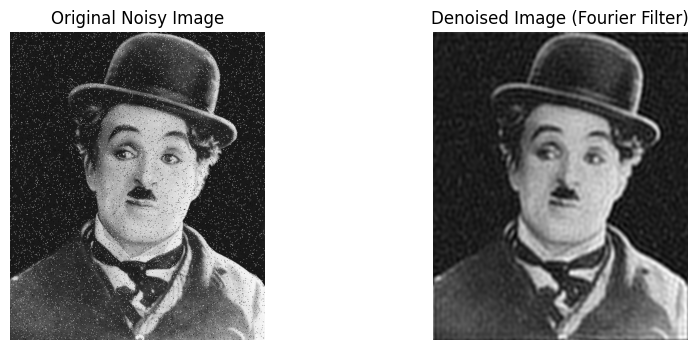

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import match_template

def fourier_denoise(image, radius=50):
    # Computing Fourier transform and shift the zero-frequency component to the center
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # Creating a circular low-pass filter mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, thickness=-1)

    # Applying the mask and inverse Fourier transform
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    image_back = np.fft.ifft2(f_ishift)
    denoised = np.abs(image_back)
    return denoised

img = cv2.imread("/content/noisy_image.png", cv2.IMREAD_GRAYSCALE)

# Checking if image loading was successful
if img is None:
    print("Error: Could not load image. Please check the file path or if the image file exists.")
    exit()

# Printing image shape to verify it's not empty incase of errors
print("Image shape:", img.shape)

denoised_img = fourier_denoise(img, radius=50)

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original Noisy Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(denoised_img, cmap='gray')
plt.title('Denoised Image (Fourier Filter)')
plt.axis('off')
plt.show()

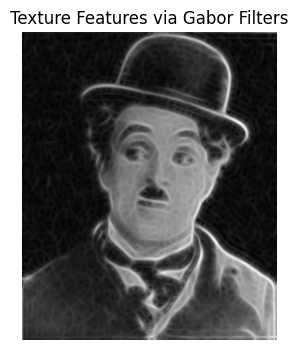

In [5]:
def create_gabor_filter_bank():
    filters = []
    num_filters = 16
    ksize = 35
    sigma = 3.0
    lambd = 10.0
    gamma = 0.5
    psi = 0
    for theta in np.arange(0, np.pi, np.pi/num_filters):
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= kern.sum() if kern.sum() != 0 else 1
        filters.append(kern)
    return filters

def apply_gabor_filter_bank(image, filters):
    responses = []
    for kern in filters:
        response = cv2.filter2D(image, -1, kern)
        responses.append(response)
    combined_response = np.max(np.stack(responses, axis=-1), axis=-1)
    return combined_response

# Creating and applying the Gabor filter bank on the denoised image
gabor_filters = create_gabor_filter_bank()
texture_img = apply_gabor_filter_bank(denoised_img, gabor_filters)

plt.figure(figsize=(8,4))
plt.imshow(texture_img, cmap='gray')
plt.title('Texture Features via Gabor Filters')
plt.axis('off')
plt.show()


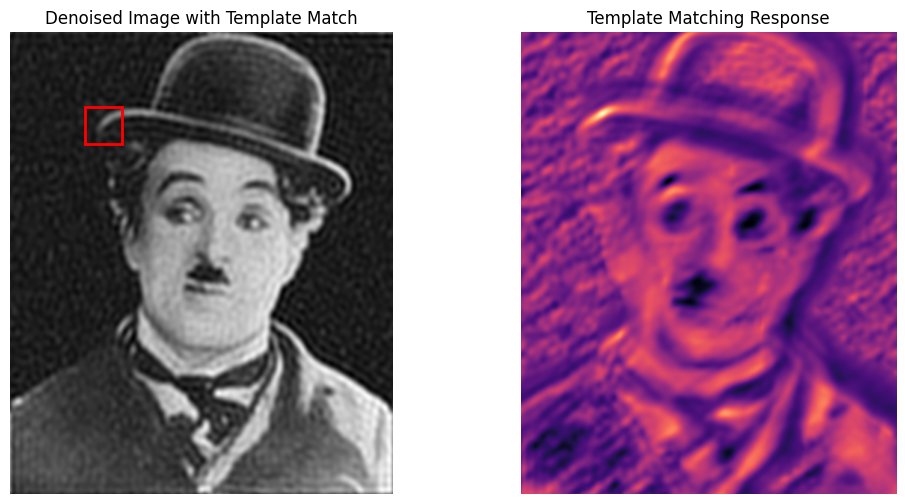

In [6]:
template = denoised_img[100:150, 100:150]

# Performing template matching on the denoised image
result = match_template(denoised_img, template)

# Finding the best match location
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij
h, w = template.shape

# Plotting the denoised image with a rectangle showing the detected template location
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(denoised_img, cmap='gray')
ax[0].set_title('Denoised Image with Template Match')
rect = plt.Rectangle((y, x), w, h, edgecolor='r', facecolor='none', linewidth=2)
ax[0].add_patch(rect)
ax[0].axis('off')

# Displaying the matching result heatmap
ax[1].imshow(result, cmap='magma')
ax[1].set_title('Template Matching Response')
ax[1].axis('off')

plt.show()
